# Fitting interaction parameters of binary systems

Sometimes Equations of State needs an extra help to better predict behaviors.

Let's see how we can optimize binary interaction parameters (BIPs) of a Cubic
Equation, using equilibrium data.

## Data structure
For all the default approaches of parameter optimization the data points must
be in the format of a `pandas` DataFrame, with the following columns:

- `kind`: Which kind of point is defined. The options are:
    - `bubbleT`
    - `bubbleP`
    - `dewT`
    - `dewP`
    - `PT`
    - `liquid-liquid`
    - `critical`
- `T`: Temperature (in Kelvin).
- `P`: Pressure (in bar).
- `x1`: Mole fraction of component 1 (lightest component) in heavy phase. 
- `y1`: Mole fraction of component 1 (lightest component) in light phase.

Optional column:
- `weight`: A column that assign a weight factor to that data point when
    calculating the error. If not provided, all weights are assumed as 1.

Depending on the specified data point `kind` the experimental error will be
calculated differently. Moreover, different information will be needed.
"Not used" information could be set as NaN (missing data) in the dataframe

+-------------------+---------------------------------------------------------------------------+----------+
| ``kind``          | Description                                                               | Not Used |
+===================+===========================================================================+==========+
| ``bubbleT``       | A saturation temperature calculation is performed                         | ``y1``   |
|                   |                                                                           |          |
|                   | using ``P`` and  the composition ``x1``.                                  |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation temperature and ``T``.                                         |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``bubbleP``       | A saturation pressure calculation is performed                            | ``y1``   |
|                   |                                                                           |          |
|                   | using ``T`` and the composition ``x1``.                                   |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation pressure and ``P``.                                            |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``dewT``          | A saturation temperature calculation is                                   | ``x1``   |
|                   |                                                                           |          |
|                   | performed using ``P`` and the composition ``y1``.                         |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation temperature and ``T``.                                         |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``dewP``          | A saturation pressure calculation is performed                            | ``x1``   |
|                   |                                                                           |          |
|                   | using ``T`` and the composition ``y1``.                                   |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | saturation pressure and ``P``.                                            |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``PT``            | A flash calculation is performed at ``T`` and ``P``.                      | —        |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated                            |          |
|                   |                                                                           |          |
|                   | light phase composition and ``y1`` (if ``y1`` is provided)                |          |
|                   |                                                                           |          |
|                   | and between the calculated heavy phase                                    |          |
|                   |                                                                           |          |
|                   | composition and ``x1`` (if ``x1`` is provided).                           |          |
|                   |                                                                           |          |
|                   | You must provide ``x1``, ``y1`` or both.                                  |          |
+-------------------+---------------------------------------------------------------------------+----------+
| ``liquid-liquid`` | Same as ``PT`` kind but a liquid-liquid flash initialization is searched. | —        |
+-------------------+---------------------------------------------------------------------------+----------+
| ``critical``      | The critical line is calculated.                                          | ``y1``   |
|                   |                                                                           |          |
|                   | Since is a critical point both ``x1`` and ``y1`` are the same.            |          |
|                   |                                                                           |          |
|                   | The error is calculated between the calculated pressure, temperature      |          |
|                   |                                                                           |          |
|                   | and composition and ``P``, ``T`` and ``x1`` respectively.                 |          |
+-------------------+---------------------------------------------------------------------------+----------+


As shown, depending on the kind of each data point, some information is
mandatory and other is not used. This behaviour allows the user to adjust
the same data points to different kinds and enhance the fitting results.

In the following cell we import the data points from a `.csv` file

In [1]:
import pandas as pd

import numpy as np


df = pd.read_csv('./data/CO2_C6.csv')

df

,kind,T,P,x1,y1
0,bubbleP,303.15,20.24,0.2385,0.9721
1,bubbleP,303.15,30.36,0.3698,0.9768
2,bubbleP,303.15,39.55,0.5063,0.9815
3,bubbleP,303.15,50.95,0.7078,0.9842
4,bubbleP,303.15,57.83,0.8430,0.9855
5,bubbleP,303.15,64.68,0.9410,0.9884
6,bubbleP,303.15,67.46,0.9656,0.9909
7,bubbleP,315.15,20.84,0.2168,0.9560
8,bubbleP,315.15,30.40,0.3322,0.9660
9,bubbleP,315.15,40.52,0.4446,0.9748


This data set consist of multiple bubble pressure data points at two different
temperatures. Both liquid (`x1`) and vapor (`y1`) light component mole
compositions are provided.

As explained before, depending on the `kind` of data point, some columns
are not used. In this case, since we are going to use `bubbleP` kind,
the `y1` column is not used, even if it is still provided in the data set.

Since the `weight` column is not provided, all data points will be equally
weighted when calculating the error.

## Default model prediction

Before starting to fit BIPs, let's see how the model predicts without BIPs.

First, let's define the model

In [2]:
import yaeos


Tc = [304.1, 504.0]     # Critical temperature in K
Pc = [73.75, 30.12]     # Critical pressure in bar
w = [0.4, 0.299]        # Acentric factor

# Peng-Robinson (1976) model without interaction parameters
model = yaeos.PengRobinson76(Tc, Pc, w)

### Calculation of Pxy diagrams

Now that the model is defined, lets calculate Pxy diagrams for each 
temperature.

First, we find the unique values of temperature to iterate over them later.

In [3]:
Ts = df["T"].unique()
Ts

array([303.15, 315.15])

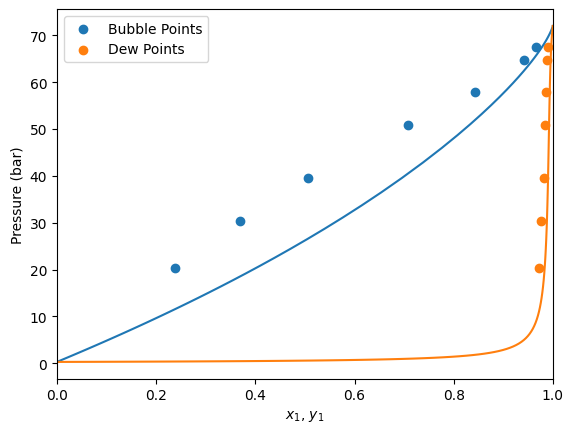

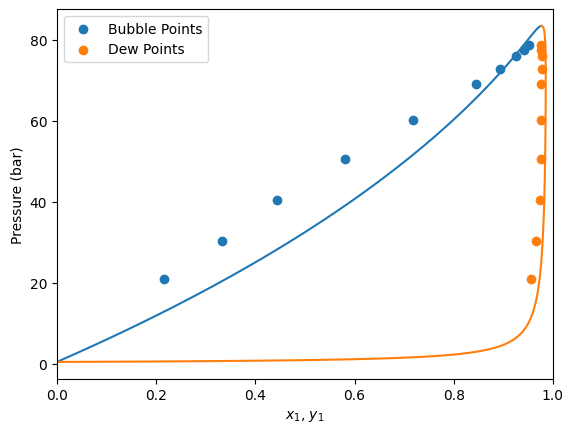

In [4]:
import matplotlib.pyplot as plt


gpec = yaeos.GPEC(model)

for T in Ts:
    msk = df["T"] == T
    pxy = gpec.plot_pxy(T)
    
    plt.scatter(df[msk]["x1"], df[msk]["P"], label="Bubble Points")
    plt.scatter(df[msk]["y1"], df[msk]["P"], label="Dew Points")
    
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

Here we can see that the PengRobinson EoS present a negative deviation with
respect to the experimental points. Let's se how we can improve these
predictions.

## Definition of the optimization problem

Now that we already have our data points defined. We need to define the
optimization problem.

The `yaeos.fitting` package includes the `BinaryFitter` object, this object
encapsulates all the logic that is needed to fit binary systems.

In [5]:
import yaeos
from yaeos.fitting import BinaryFitter


help(BinaryFitter)

Help on class BinaryFitter in module yaeos.fitting.core:

class BinaryFitter(builtins.object)
 |  BinaryFitter(model_setter: Callable, model_setter_args: tuple, data: pandas.core.frame.DataFrame, verbose: bool = False, pressure_error: Callable = None, temperature_error: Callable = None, composition_error: Callable = None) -> None
 |
 |  BinaryFitter class.
 |
 |  This class is used to fit binary interaction parameters to experimental
 |  data. The objective function is defined as the sum of the squared errors
 |  between the experimental data and the model predictions.
 |
 |  Parameters
 |  ----------
 |  model_setter : Callable
 |      A function that returns a model object. The function should take the
 |      optimization parameters as the first argument and any other arguments
 |      as the following arguments.
 |  model_setter_args : tuple
 |      A tuple with the arguments to pass to the model_setter function.
 |  data : pandas.DataFrame
 |      A DataFrame with the experimental

### Model setter function

Looking at the object's documentation we can see that we need to define a
function `model_setter`.

This is a user-defined function that sets and returns the Equation of State in
function of the fitting parameters and extra required arguments.

The `model_setter` signature is as follows:

```python
def model_setter(parameters_to_fit, *args) -> yaeos.core.ArModel:
    """
    Function to set the Equation of State model.

    Parameters
    ----------
    parameters_to_fit : array_like
        Array that contains the parameters to fit.
    *args : tuple
        Extra arguments required by the model.

    Returns
    -------
    yaeos.core.ArModel
        The Equation of State model with the specified parameters.
    """

    # Code that sets an Equation of State model.

```

The extra arguments of the `model_setter` are passed to the BinaryFitter object
when it is initialized. Let's see an example to fit the $k_{ij}$ values of the
quadratic mixing rule (QMR) for the Peng-Robinson (1976) EoS.

In [6]:
def fit_kij(x, Tcs, Pcs, ws):
    """Fit kij function of QMR.

    Parameters
    ----------
    x : array_like
        List of interaction parameters (kij) to fit.
    Tcs : array_like
        Critical temperatures of the components in K.
    Pcs : array_like
        Critical pressures of the components in bar.
    ws : array_like
        Acentric factors of the components.
    """
    # Create the kij matrix from the argument
    kij = x[0]

    kij_matrix = [
        [0, kij], 
        [kij, 0]
    ]

    # lij matrix is null, we are only fitting kij.
    lij = [
        [0, 0],
        [0, 0]
    ]

    # Setting of the mixing rule
    mixrule = yaeos.QMR(kij=kij_matrix, lij=lij)

    # Create the Peng-Robinson (1976) model with the mixing rule
    model = yaeos.PengRobinson76(Tcs, Pcs, ws, mixrule=mixrule)
    
    # return the model
    return model

With the `model_setter` function defined we can instantiate a BinaryFitter
object. Let's see how we can do that.

In [7]:
# The parameters of the substances
Tc = [304.1, 504.0]     # Critical temperature in K
Pc = [73.75, 30.12]     # Critical pressure in bar
w = [0.4, 0.299]        # Acentric factor

# Instantiate the BinaryFitter
problem = BinaryFitter(
    model_setter=fit_kij,           # model_setter function
    model_setter_args=(Tc, Pc, w),  # Extra arguments for the model_setter
    data=df,                        # Data to fit   
    verbose=True                    # Print information during the fitting process
)

# Initial guess for the fitting parameters (kij)
x0 = [0.0]

# Call the fit method with the initial guess and fit the model
problem.fit(x0, bounds=None)

1 1.7427277505415613 [0.]
2 1.7367297562170219 [0.00025]
3 1.7307370070279757 [0.0005]
4 1.724749524359144 [0.00075]
5 1.7127904444575115 [0.00125]
6 1.7008526887828561 [0.00175]
7 1.6770418452848828 [0.00275]
8 1.6533183938127916 [0.00375]
9 1.6061393524838132 [0.00575]
10 1.559327110667044 [0.00775]
11 1.466850636237784 [0.01175]
12 1.3759871691006067 [0.01575]
13 1.1995171239389069 [0.02375]
14 1.0308070867724293 [0.03175]
15 0.720712550588943 [0.04775]
16 0.4549489017208965 [0.06375]
17 0.1629893787067825 [0.09575]
18 0.21973945390710206 [0.12775]
19 0.21973945390710206 [0.12775]
20 0.09748392400879796 [0.11175]
21 0.21973945390710206 [0.12775]
22 0.11792833339944278 [0.10375]
23 0.10555975931245845 [0.11975]
24 0.097806384418106 [0.11575]
25 0.10412405294278751 [0.10775]
26 0.09666848514043408 [0.11375]
27 0.097806384418106 [0.11575]
28 0.09685432239927533 [0.11275]
29 0.055998484514111685 [0.11475]
30 0.097806384418106 [0.11575]
31 0.097806384418106 [0.11575]
32 0.055375063895750

We can check the arguments of the `fit` method.

The first argument x0 is the initial guess for the fitting parameters.

The second argument, `bounds`, could be used to set the optimization bounds of the
interaction parameters. Is defined as a tuple of two arrays, the first one
contains the lower bounds and the second one contains the upper bounds for each
parameter. To not specify bounds, set it to `None`.

The third argument, `method`, is used to select the optimization method.
The default method is `"Nelder-Mead"`. Check the `scipy.optimize.minimize`
documentation for more information about the available methods.

In [8]:
help(problem.fit)

Help on method fit in module yaeos.fitting.core:

fit(x0, bounds=None, method='Nelder-Mead', optimizer_options=None) method of yaeos.fitting.core.BinaryFitter instance
    Fit the model to the data.

    Fit the model to the data using the objective function defined in
    the objective_function method. The optimization is performed using
    the scipy.optimize.minimize function.
    The optimization result is stored in the `.solution` property. Which

    Parameters
    ----------
    x0 : array-like
        Initial guess for the fitting parameters.
    bounds : array-like
        Bounds for the fitting parameters.
    method : str, optional
        The optimization method to use. Default is 'Nelder-Mead'.

    Returns
    -------
    None



## Optimization result
Now that we have fitted the parameter, let's check the solution. For this, we
can access the `solution` attribute of `problem`.

As shown we can see that the optimization terminated successfully with a `kij`
value of around `0.113`

In [9]:
problem.solution

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.05498185301289581
             x: [ 1.139e-01]
           nit: 21
          nfev: 42
 final_simplex: (array([[ 1.139e-01],
                       [ 1.139e-01]]), array([ 5.498e-02,  5.504e-02]))

### Obtain the fitted model
Now that the problem has been optimized, let's redefine our model with the
solution. 

For this, we use the `get_model` method inside the `BinaryFitter` object. This
just uses the function that we have provided originally (`fit_kij`) to return
the model with the specified parameters.

In [10]:
# Obtain the fitted model specifying the solution of the fitting and the parameters of the substances
model = problem.get_model(problem.solution.x, Tc, Pc, w)

### Make predictions
Let's repeat the calculation of Pxy diagrams that we have done earlier

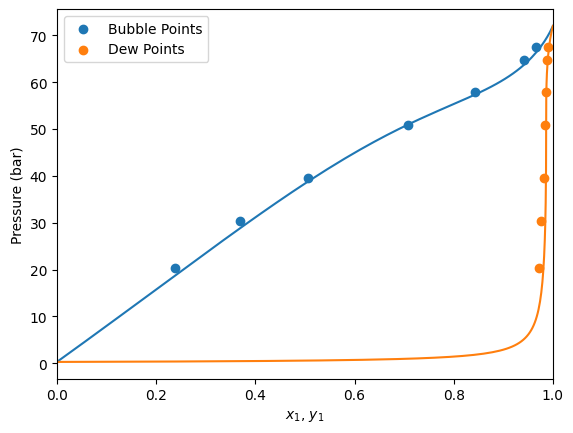

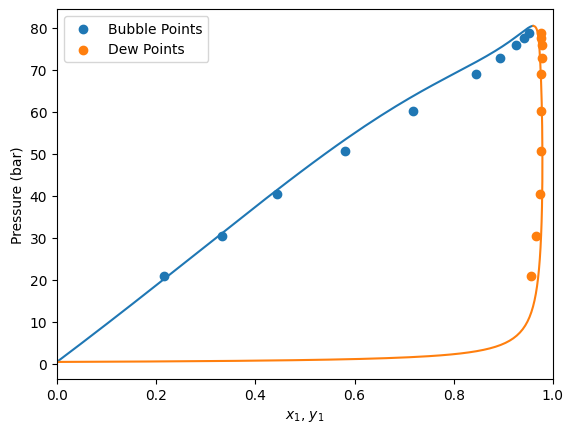

In [11]:
import matplotlib.pyplot as plt


gpec = yaeos.GPEC(model)

for T in Ts:
    msk = df["T"] == T
    pxy = gpec.plot_pxy(T)
    
    plt.scatter(df[msk]["x1"], df[msk]["P"], label="Bubble Points")
    plt.scatter(df[msk]["y1"], df[msk]["P"], label="Dew Points")
    
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

## Another example

Let's check another example of fitting BIPs. First, we need to read the data.

In [12]:
import pandas as pd


df = pd.read_csv("data/C1_benzene.csv")

# Temperature of the experimental data
T = 373

df

,kind,T,P,x1,y1,weight
0,bubbleP,373,146.253230,0.240633,NaN,NaN
1,bubbleP,373,201.162791,0.348109,NaN,NaN
2,bubbleP,373,249.612403,0.443787,NaN,NaN
3,bubbleP,373,288.372093,0.553794,NaN,NaN
4,bubbleP,373,296.770026,0.606126,NaN,NaN
5,bubbleP,373,146.899225,0.238022,NaN,NaN
6,bubbleP,373,179.198966,0.299628,NaN,NaN
7,bubbleP,373,218.604651,0.380880,NaN,NaN
8,bubbleP,373,234.108527,0.412334,NaN,NaN
9,bubbleP,373,246.382429,0.443771,NaN,NaN


Here we have a data set of bubble pressures and dew pressures all at 373 K.
Moreover, the critical point is also provided at 373 K.

In this mixture of different data `kind`, the not used information is set as
NaN (missing data) in the dataframe.

First, we are going to instantiate a Peng-Robinson EoS model without BIPs
and see how it predicts the data.

In [13]:
# Substance properties
Tc = [190.564, 562.05]      # Critical temperatures in K
Pc = [45.99, 48.95]         # Critical pressures in bar
w = [0.0115478, 0.2103]     # Acentric factors
Zc = [0.286, 0.268]         # Critical compressibility factors


model = yaeos.RKPR(Tc, Pc, w, Zc)

Now let's plot the experimental data and the model predictions.

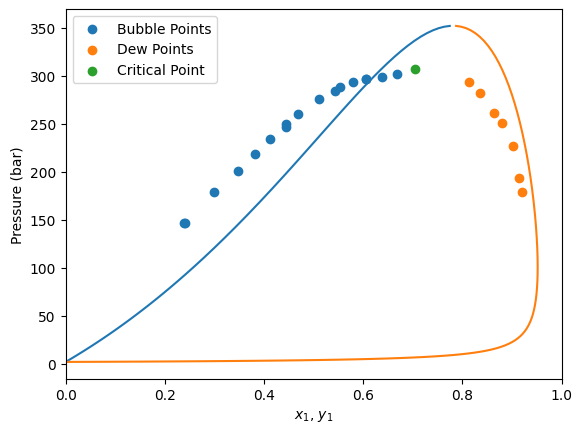

In [14]:
import matplotlib.pyplot as plt


gpec = yaeos.GPEC(model)
pxy = gpec.plot_pxy(T)


msk_bub = df["kind"] == "bubbleP"
msk_dew = df["kind"] == "dewP"
msk_critical = df["kind"] == "critical"

plt.scatter(df[msk_bub]["x1"], df[msk_bub]["P"], label="Bubble Points")
plt.scatter(df[msk_dew]["y1"], df[msk_dew]["P"], label="Dew Points")
plt.scatter(df[msk_critical]["x1"], df[msk_critical]["P"], label="Critical Point")

plt.xlim(0, 1)
plt.legend()
plt.show()

In [15]:
def fit_kij(x, Tcs, Pcs, ws, Zc):
    """Fit kij function of QMR.

    Parameters
    ----------
    x : array_like
        List of interaction parameters (kij) to fit.
    Tcs : array_like
        Critical temperatures of the components in K.
    Pcs : array_like
        Critical pressures of the components in bar.
    ws : array_like
        Acentric factors of the components.
    """
    # Create the kij matrix from the argument
    kij = x[0]

    kij_matrix = [
        [0, kij], 
        [kij, 0]
    ]

    # lij matrix is null, we are only fitting kij.
    lij = [
        [0, 0],
        [0, 0]
    ]

    # Setting of the mixing rule
    mixrule = yaeos.QMR(kij=kij_matrix, lij=lij)

    # Create the Peng-Robinson (1976) model with the mixing rule
    model = yaeos.RKPR(Tcs, Pcs, ws, Zc, mixrule=mixrule)
    
    # return the model
    return model


problem = BinaryFitter(
    model_setter=fit_kij,           # model_setter function
    model_setter_args=(Tc, Pc, w, Zc),  # Extra arguments for the model_setter
    data=df,                        # Data to fit   
    verbose=True                    # Print information during the fitting process
)

In [16]:
x0 = np.array([0.0])

problem.fit(x0=x0, bounds=None)

1 12.712963199267698 [0.]
2 12.738758644146133 [0.00025]
3 12.727097643389397 [-0.00025]


4 13.120643145001315 [-0.000125]
5 12.729341979580035 [0.000125]
6 13.120643145001315 [-0.000125]


7 12.714133131974073 [6.25e-05]
8 13.022940277490937 [-6.25e-05]
9 12.731905458201426 [3.125e-05]


10 12.731905458201426 [3.125e-05]
11 12.939722406692617 [-3.125e-05]
12 12.780402611800946 [1.5625e-05]


13 12.780402611800946 [1.5625e-05]
14 12.869472078230137 [-1.5625e-05]


15 12.732060601202438 [7.8125e-06]
16 12.894262273574384 [-7.8125e-06]
17 12.710539267713635 [3.90625e-06]


18 12.732060601202438 [7.8125e-06]
19 12.707253993250536 [1.953125e-06]
20 12.712963199267698 [0.]


21 12.813249182922187 [2.9296875e-06]
22 12.813249182922187 [2.9296875e-06]
23 12.730931855138863 [9.765625e-07]


24 12.846447529225356 [1.46484375e-06]
25 12.791494334593745 [2.44140625e-06]
26 12.846447529225356 [1.46484375e-06]


27 12.759807723536193 [2.19726563e-06]
28 12.833978937563684 [1.70898437e-06]
29 12.793256508027438 [2.07519531e-06]


30 12.793256508027438 [2.07519531e-06]
31 12.706904203474258 [1.83105469e-06]
32 12.833978937563684 [1.70898437e-06]


33 12.833978937563684 [1.70898437e-06]
34 12.724244815099478 [1.89208984e-06]
35 12.724244815099478 [1.89208984e-06]


36 12.709020465449855 [1.77001953e-06]
37 12.796523026455555 [1.80053711e-06]
38 12.73296049330389 [1.86157227e-06]


39 12.796523026455555 [1.80053711e-06]
40 12.71371545661073 [1.84631348e-06]
41 12.752148777530893 [1.8157959e-06]


42 12.712008391142586 [1.83868408e-06]
43 12.713831928195908 [1.82342529e-06]
44 12.7533551855147 [1.83486938e-06]


45 12.7533551855147 [1.83486938e-06]
46 13.094977173670399 [1.82723999e-06]
47 12.712330012838848 [1.83296204e-06]


48 12.71826309326905 [1.82914734e-06]
49 12.799365473238572 [1.83200836e-06]
50 12.799365473238572 [1.83200836e-06]


51 12.732858198204553 [1.83010101e-06]
52 12.709115117345933 [1.83057785e-06]
53 12.765447752157783 [1.83153152e-06]


54 12.722287531285867 [1.83081627e-06]
55 12.722287531285867 [1.83081627e-06]
56 12.773712163869986 [1.83129311e-06]


57 12.706926770129835 [1.83093548e-06]


In [17]:
model = problem.get_model(problem.solution.x, Tc, Pc, w, Zc)

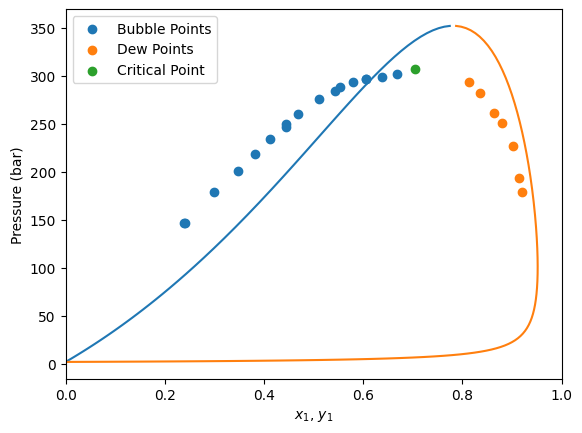

In [18]:
import matplotlib.pyplot as plt


gpec = yaeos.GPEC(model)
pxy = gpec.plot_pxy(T)


msk_bub = df["kind"] == "bubbleP"
msk_dew = df["kind"] == "dewP"
msk_critical = df["kind"] == "critical"

plt.scatter(df[msk_bub]["x1"], df[msk_bub]["P"], label="Bubble Points")
plt.scatter(df[msk_dew]["y1"], df[msk_dew]["P"], label="Dew Points")
plt.scatter(df[msk_critical]["x1"], df[msk_critical]["P"], label="Critical Point")

plt.xlim(0, 1)
plt.legend()
plt.show()

In [19]:
def fit_nrtl_hv(x, Tc, Pc, ws, Zc):
    g12, g21 = x[:2]
    alpha = x[2]
    gji = [[0, g12], [g21, 0]]
    alpha = [[0, alpha], [alpha, 0]]
    use_kij = [[False, False], [False, False]]
    
    kij = [[0, 0], [0, 0]]
    
    mixrule = yaeos.HVNRTL(alpha=alpha, gji=gji, use_kij=use_kij, kij=kij)
    
    model = yaeos.RKPR(Tc, Pc, ws, Zc, mixrule=mixrule)
    
    return model

In [20]:
Tc = [190.564, 562.05]      # Critical temperatures in K
Pc = [45.99, 48.95]         # Critical pressures in bar
w = [0.0115478, 0.2103]     # Acentric factors
Zc = [0.286, 0.268]         # Critical compressibility factors

problem = BinaryFitter(
    model_setter=fit_nrtl_hv,              # model_setter function
    model_setter_args=(Tc, Pc, w, Zc),  # Extra arguments for the model_setter
    data=df,                            # Data to fit
    verbose=True                        # Print information during the fitting process
)

In [21]:
x0 = [31.81663237,  4.10864439, -1.3615617]
problem.fit(x0=x0, bounds=None, method="Powell")

1 0.4771801039886128 [31.81663237  4.10864439 -1.3615617 ]


2 0.4771801039886128 [31.81663237  4.10864439 -1.3615617 ]
3 0.5793862089572653 [32.81663237  4.10864439 -1.3615617 ]


4 0.6439484108295415 [30.19859837  4.10864439 -1.3615617 ]


5 0.504847345199201 [31.1985984   4.10864439 -1.3615617 ]


6 0.4828032100880742 [32.19859837  4.10864439 -1.3615617 ]


7 0.496470533560624 [31.88388052  4.10864439 -1.3615617 ]


8 0.5047613233674523 [31.5805644   4.10864439 -1.3615617 ]


9 0.4868647558887811 [31.72646243  4.10864439 -1.3615617 ]


10 0.5137209585788234 [31.78219052  4.10864439 -1.3615617 ]


11 0.478461133806893 [31.84231888  4.10864439 -1.3615617 ]
12 0.4879854546406249 [31.80347675  4.10864439 -1.3615617 ]


13 0.48319319203451977 [31.82644374  4.10864439 -1.3615617 ]
14 0.48666768562904067 [31.81160737  4.10864439 -1.3615617 ]


15 0.5764469377738142 [31.82037998  4.10864439 -1.3615617 ]


16 0.4756413337186007 [31.81471299  4.10864439 -1.3615617 ]


17 0.4902081490845852 [31.81352675  4.10864439 -1.3615617 ]
18 0.4924278978541007 [31.81544613  4.10864439 -1.3615617 ]


19 0.48036772187391436 [31.81425989  4.10864439 -1.3615617 ]


20 0.5131892001904141 [31.81499303  4.10864439 -1.3615617 ]


21 0.5310504993570806 [31.81453992  4.10864439 -1.3615617 ]


22 0.5241075587544506 [31.81481995  4.10864439 -1.3615617 ]


23 0.5065243286265566 [31.81464688  4.10864439 -1.3615617 ]


24 0.4822810829164419 [31.81475385  4.10864439 -1.3615617 ]
25 0.517617273009654 [31.81468774  4.10864439 -1.3615617 ]


26 0.47368639438847265 [31.81473219  4.10864439 -1.3615617 ]
27 0.47368639438847265 [31.81473219  4.10864439 -1.3615617 ]


28 1.3313935340073002 [31.81473219  5.10864439 -1.3615617 ]


29 1.3038219252427978 [31.81473219  2.49061039 -1.3615617 ]


30 0.5368626834094227 [31.81473219  3.49061042 -1.3615617 ]


31 0.6612394083755757 [31.81473219  4.49061039 -1.3615617 ]


32 0.4512610167078458 [31.81473219  3.88578234 -1.3615617 ]


33 0.46189672728379155 [31.81473219  3.89919813 -1.3615617 ]
34 0.5562905147012287 [31.81473219  3.7348401  -1.3615617 ]


35 0.5435333898134957 [31.81473219  3.82812754 -1.3615617 ]


36 0.5464544178801641 [31.81473219  3.86376017 -1.3615617 ]


37 0.45330589195478893 [31.81473219  3.87737062 -1.3615617 ]
38 0.46730813564307155 [31.81473219  3.88355372 -1.3615617 ]


39 0.4627805881936456 [31.81473219  3.88801096 -1.3615617 ]


40 0.4512610167078458 [31.81473219  3.88578234 -1.3615617 ]


41 11.682459282291338 [31.81473219  3.88578234 -0.3615617 ]
42 30.577311626570225 [31.81473219  3.88578234 -2.9795957 ]


43 9.033103999194836 [31.81473219  3.88578234 -1.97959567]


44 3.429917341293864 [31.81473219  3.88578234 -0.9795957 ]
45 0.5577320917382419 [31.81473219  3.88578234 -1.35039437]


46 2.0256889057489973 [31.81473219  3.88578234 -1.59762967]


47 0.7107568373261405 [31.81473219  3.88578234 -1.42871461]


48 0.4784332666429495 [31.81473219  3.88578234 -1.38384393]


49 0.47526483444210127 [31.81473219  3.88578234 -1.37080623]


50 0.4497140542276316 [31.81473219  3.88578234 -1.35729616]


51 0.5064624023514994 [31.81473219  3.88578234 -1.35833227]


52 0.5253259307305553 [31.81473219  3.88578234 -1.35465991]


53 0.4755834737288106 [31.81473219  3.88578234 -1.3562892 ]


54 0.4504487158160641 [31.81473219  3.88578234 -1.35769192]


55 0.45905414887587853 [31.81473219  3.88578234 -1.35691154]


56 0.4896378228645743 [31.81473219  3.88578234 -1.35744733]


57 0.5674488120058178 [31.81473219  3.88578234 -1.35714925]


58 0.5056022916938473 [31.81473219  3.88578234 -1.3573539 ]


59 0.4761394848728853 [31.81473219  3.88578234 -1.35724004]


60 0.49649432343419336 [31.812832    3.66292029 -1.35303062]
61 0.4497140542276316 [31.81473219  3.88578234 -1.35729616]


62 0.5165579781207665 [32.81473219  3.88578234 -1.35729616]


63 0.8308767237576069 [30.19669819  3.88578234 -1.35729616]


64 0.4986820727168987 [31.19669821  3.88578234 -1.35729616]


65 0.4566921288983934 [32.19669819  3.88578234 -1.35729616]
66 0.46190078236420257 [31.91202957  3.88578234 -1.35729616]


67 0.4595029764879952 [31.57866422  3.88578234 -1.35729616]


68 0.654584787057849 [31.9112087   3.88578234 -1.35729616]


69 0.4512338581279687 [31.72456225  3.88578234 -1.35729616]


70 0.46392163967981404 [31.88292959  3.88578234 -1.35729616]


71 0.45792250294154874 [31.78029034  3.88578234 -1.35729616]


72 0.4493320387124173 [31.84078127  3.88578234 -1.35729616]


73 0.4502289402119966 [31.8568805   3.88578234 -1.35729616]


74 0.49116854771556817 [31.83214824  3.88578234 -1.35729616]
75 0.4760904662460551 [31.84693063  3.88578234 -1.35729616]


76 0.5426482292069321 [31.83748375  3.88578234 -1.35729616]


77 0.47171379817060566 [31.84313012  3.88578234 -1.35729616]


78 0.5276438198319687 [31.83952173  3.88578234 -1.35729616]
79 0.4815144265835681 [31.84167845  3.88578234 -1.35729616]


80 0.46765069597515874 [31.84030017  3.88578234 -1.35729616]
81 0.45268041406536286 [31.84112397  3.88578234 -1.35729616]


82 0.4493320387124173 [31.84078127  3.88578234 -1.35729616]
83 1.0157045260969004 [31.84078127  4.88578234 -1.35729616]


84 1.5541004076559033 [31.84078127  2.26774834 -1.35729616]
85 0.6655160128068696 [31.84078127  3.26774837 -1.35729616]


86 0.5580823845232543 [31.84078127  4.26774834 -1.35729616]


87 0.47109556661886787 [31.84078127  3.85240774 -1.35729616]


88 0.4615142190726294 [31.84078127  4.01365093 -1.35729616]


89 0.5058241763964029 [31.84078127  3.9346238  -1.35729616]


90 0.4586876073963549 [31.84078127  3.90443812 -1.35729616]


91 0.4853436846078533 [31.84078127  3.87303438 -1.35729616]


92 0.4499103717863095 [31.84078127  3.89290821 -1.35729616]


93 0.45914874338403344 [31.84078127  3.88823213 -1.35729616]


94 0.46629794819552245 [31.84078127  3.88091305 -1.35729616]


95 0.49606405181120145 [31.84078127  3.88392244 -1.35729616]
96 0.4521926105393584 [31.84078127  3.88671808 -1.35729616]


97 0.44932915918957617 [31.84078127  3.88507192 -1.35729616]
98 0.4920528584247801 [31.84078127  3.88522117 -1.35729616]


99 0.48923233128976945 [31.84078127  3.88506482 -1.35729616]


100 0.45146294741798654 [31.84078127  3.88512893 -1.35729616]
101 0.5984714532671623 [31.84078127  3.8850937  -1.35729616]


102 0.4860934534787147 [31.84078127  3.88508024 -1.35729616]
103 0.44932915918957617 [31.84078127  3.88507192 -1.35729616]


104 11.76823696869633 [31.84078127  3.88507192 -0.35729616]
105 30.526659048420953 [31.84078127  3.88507192 -2.97533016]


106 8.949634845394305 [31.84078127  3.88507192 -1.97533013]


107 3.3664291127237878 [31.84078127  3.88507192 -0.97533016]


108 0.5647702250095699 [31.84078127  3.88507192 -1.34482562]
109 1.9975837697336454 [31.84078127  3.88507192 -1.59336412]


110 0.6062186256521737 [31.84078127  3.88507192 -1.42379744]


111 0.5191240535923971 [31.84078127  3.88507192 -1.38252747]


112 0.4693446492220216 [31.84078127  3.88507192 -1.36557478]


113 0.45281034864325903 [31.84078127  3.88507192 -1.35253284]


114 0.48296411852957893 [31.84078127  3.88507192 -1.35642812]
115 0.5200188023219334 [31.84078127  3.88507192 -1.36045831]


116 0.4524252863178477 [31.84078127  3.88507192 -1.35850399]


117 0.5196253125365767 [31.84078127  3.88507192 -1.35775751]


118 0.48533000919324437 [31.84078127  3.88507192 -1.3569646 ]


119 0.4517909317099833 [31.84078127  3.88507192 -1.35747238]
120 0.5342033596813898 [31.84078127  3.88507192 -1.35716951]


121 0.4902369558239464 [31.84078127  3.88507192 -1.35736347]


122 0.4844793652937558 [31.84078127  3.88507192 -1.35724779]


123 0.4624298704419253 [31.84078127  3.88507192 -1.35732187]


124 0.4849265809822952 [31.84078127  3.88507192 -1.35727768]


125 0.4640915874232172 [31.84078127  3.88507192 -1.35730598]


126 0.4788656282525948 [31.84078127  3.88507192 -1.3572891 ]
127 0.5139648225058733 [31.84078127  3.88507192 -1.35729991]


128 0.4854200430541733 [31.84078127  3.88507192 -1.35729346]
129 0.4961070916842856 [31.84078127  3.88507192 -1.35729759]


130 0.4556902452698185 [31.84078127  3.88507192 -1.35729513]


131 0.46509661389789814 [31.84078127  3.88507192 -1.35729671]


132 0.47593701505282554 [31.84078127  3.88507192 -1.35729577]


133 0.45969555679905 [31.84078127  3.88507192 -1.35729637]
134 0.45764452675896605 [31.84078127  3.88507192 -1.35729601]


135 0.48792539573284055 [31.84078127  3.88507192 -1.35729624]
136 0.44944812404180867 [31.84078127  3.88507192 -1.3572961 ]


137 0.45305505029216564 [31.84078127  3.88507192 -1.35729619]
138 0.46069222375170804 [31.84078127  3.88507192 -1.35729614]


139 0.5349512236728584 [31.84078127  3.88507192 -1.35729617]


140 0.44925581940253656 [31.84078127  3.88507192 -1.35729615]
141 0.5690697169884282 [31.84078127  3.88507192 -1.35729615]


142 0.4895373627772341 [31.84078127  3.88507192 -1.35729615]
143 0.5621235062492357 [31.84078127  3.88507192 -1.35729615]


144 0.5367105920543712 [31.84078127  3.88507192 -1.35729615]
145 0.45689169085520603 [31.84078127  3.88507192 -1.35729615]


146 0.4579067507932959 [31.84078127  3.88507192 -1.35729615]


147 0.5167521202205964 [31.84078127  3.88507192 -1.35729615]
148 0.4494924476334472 [31.84078127  3.88507192 -1.35729615]


149 0.4978056441085691 [31.84078127  3.88507192 -1.35729615]
150 0.4727624225081499 [31.86683036  3.8843615  -1.35729614]


151 0.44925581940253656 [31.84078127  3.88507192 -1.35729615]


152 0.5518110110467113 [32.84078127  3.88507192 -1.35729615]


153 0.6403753848600766 [30.22274727  3.88507192 -1.35729615]
154 0.4947019622797839 [31.2227473   3.88507192 -1.35729615]


155 0.45813814141060405 [32.22274727  3.88507192 -1.35729615]


156 0.44960298593212156 [31.91163414  3.88507192 -1.35729615]


157 0.4853985228224074 [31.83468089  3.88507192 -1.35729615]


158 0.5558997893994422 [31.86784466  3.88507192 -1.35729615]


159 0.4733259807917959 [31.85111857  3.88507192 -1.35729615]
160 0.45212303590765585 [31.84472977  3.88507192 -1.35729615]


161 0.5016786654737524 [31.83845114  3.88507192 -1.35729615]


162 0.54241256824351 [31.84228946  3.88507192 -1.35729615]


163 0.4518984893487999 [31.83989124  3.88507192 -1.35729615]


164 0.4570896808062552 [31.84135735  3.88507192 -1.35729615]


165 0.46030593581150875 [31.84044131  3.88507192 -1.35729615]


166 0.4550420863418711 [31.84100132  3.88507192 -1.35729615]


167 0.4677415478533845 [31.84065142  3.88507192 -1.35729615]


168 0.45621710697815443 [31.84086532  3.88507192 -1.35729615]


169 0.5465925093491926 [31.84073167  3.88507192 -1.35729615]


170 0.4768081901122827 [31.84081338  3.88507192 -1.35729615]


171 0.4546780703922363 [31.84076233  3.88507192 -1.35729615]


172 0.4840840681328774 [31.84079354  3.88507192 -1.35729615]


173 0.562567719134154 [31.84077404  3.88507192 -1.35729615]


174 0.4543380818104077 [31.84078596  3.88507192 -1.35729615]


175 0.5009576176435292 [31.84077851  3.88507192 -1.35729615]
176 0.5518772804420348 [31.84078306  3.88507192 -1.35729615]


177 0.5447254345762136 [31.84078022  3.88507192 -1.35729615]


178 0.4717854889920683 [31.84078196  3.88507192 -1.35729615]


179 0.5650255759380655 [31.84078087  3.88507192 -1.35729615]


180 0.4492224243220504 [31.84078153  3.88507192 -1.35729615]
181 0.4537703424094633 [31.8407817   3.88507192 -1.35729615]


182 0.48461506459762616 [31.84078144  3.88507192 -1.35729615]


183 0.5095811408571991 [31.8407816   3.88507192 -1.35729615]


184 0.5727510769488106 [31.8407815   3.88507192 -1.35729615]


185 0.49157768989327416 [31.84078156  3.88507192 -1.35729615]


186 0.502033395686352 [31.84078152  3.88507192 -1.35729615]


187 0.4527180783884138 [31.84078154  3.88507192 -1.35729615]


188 0.4817347234946003 [31.84078153  3.88507192 -1.35729615]
189 0.4516186613064822 [31.84078154  3.88507192 -1.35729615]


190 0.478919126045866 [31.84078153  3.88507192 -1.35729615]


191 0.4492224243220504 [31.84078153  3.88507192 -1.35729615]
192 1.0343951064936774 [31.84078153  4.88507192 -1.35729615]


193 1.5205738587900828 [31.84078153  2.26703792 -1.35729615]


194 0.6364891140695664 [31.84078153  3.26703795 -1.35729615]


195 0.5292321762637953 [31.84078153  4.26703792 -1.35729615]
196 0.4836579910804645 [31.84078153  3.87168454 -1.35729615]


197 0.5294800206269139 [31.84078153  4.06116947 -1.35729615]


198 0.46549791293720466 [31.84078153  3.9523352  -1.35729615]


199 0.4910309574610383 [31.84078153  3.91523637 -1.35729615]


200 0.4496416275005518 [31.84078153  3.89659372 -1.35729615]


201 0.45337520213188653 [31.84078153  3.88590034 -1.35729615]


202 0.467926659685339 [31.84078153  3.8799584  -1.35729615]


203 0.4893625607905331 [31.84078153  3.88311873 -1.35729615]


204 0.5178983787109536 [31.84078153  3.88432587 -1.35729615]


205 0.4534580606272115 [31.84078153  3.88538835 -1.35729615]


206 0.453640683641847 [31.84078153  3.88478696 -1.35729615]


207 0.4694419457020566 [31.84078153  3.88519279 -1.35729615]


208 0.48889515018086116 [31.84078153  3.88496308 -1.35729615]


209 0.4566138234848789 [31.84078153  3.88511809 -1.35729615]


210 0.5239536008602781 [31.84078153  3.88503035 -1.35729615]


211 0.5501722436912706 [31.84078153  3.88508956 -1.35729615]
212 0.4629585645613167 [31.84078153  3.88505604 -1.35729615]


213 0.4507739084801281 [31.84078153  3.88507866 -1.35729615]


214 0.4545135561984264 [31.84078153  3.88506586 -1.35729615]


215 0.4786625082538778 [31.84078153  3.8850745  -1.35729615]
216 0.5691070682421556 [31.84078153  3.88506961 -1.35729615]


217 0.45323135626835365 [31.84078153  3.88507291 -1.35729615]
218 0.45277331549157657 [31.84078153  3.88507104 -1.35729615]


219 0.5720179449318199 [31.84078153  3.8850723  -1.35729615]


220 0.4765072774584524 [31.84078153  3.88507158 -1.35729615]


221 0.4582663113485742 [31.84078153  3.88507207 -1.35729615]
222 0.4903605587971536 [31.84078153  3.88507179 -1.35729615]


223 0.47857833672990396 [31.84078153  3.88507198 -1.35729615]


224 0.45179081557720907 [31.84078153  3.88507187 -1.35729615]
225 0.4830205270357987 [31.84078153  3.88507194 -1.35729615]


226 0.44947713004702167 [31.84078153  3.8850719  -1.35729615]


227 0.4500038355935021 [31.84078153  3.88507193 -1.35729615]
228 0.464913371688947 [31.84078153  3.88507192 -1.35729615]


229 0.44998658294297256 [31.84078153  3.88507193 -1.35729615]
230 0.4842859154259152 [31.84078153  3.88507192 -1.35729615]


231 0.46088931835036534 [31.84078153  3.88507192 -1.35729615]
232 0.45972548967954696 [31.84078153  3.88507192 -1.35729615]


233 0.4495066124983268 [31.84078153  3.88507192 -1.35729615]
234 0.510150092474142 [31.84078153  3.88507192 -1.35729615]


235 0.5243463529502239 [31.84078153  3.88507192 -1.35729615]


236 0.4676973333772007 [31.84078153  3.88507192 -1.35729615]


237 0.45216457483558725 [31.84078153  3.88507192 -1.35729615]
238 0.4669630943378651 [31.84078153  3.88507192 -1.35729615]


239 0.5175217885339295 [31.84078153  3.88507192 -1.35729615]


240 0.4980921437413133 [31.84078153  3.88507192 -1.35729615]


241 0.4492491342702827 [31.84078153  3.88507192 -1.35729615]


242 0.4535505848099731 [31.84078153  3.88507192 -1.35729615]


243 0.4492224243220504 [31.84078153  3.88507192 -1.35729615]


244 12.016065209572695 [31.84078153  3.88507192 -0.35729615]
245 30.573573224977654 [31.84078153  3.88507192 -2.97533015]


246 9.051058690545922 [31.84078153  3.88507192 -1.97533013]


247 3.369259981729178 [31.84078153  3.88507192 -0.97533015]
248 0.44919735404314254 [31.84078153  3.88507192 -1.34358025]


249 0.48759724045883396 [31.84078153  3.88507192 -1.35039419]
250 1.0151173535142513 [31.84078153  3.88507192 -1.20292123]


251 0.6219292393281887 [31.84078153  3.88507192 -1.28985329]


252 0.5593984933151916 [31.84078153  3.88507192 -1.32305838]
253 0.4718298494732281 [31.84078153  3.88507192 -1.33574159]


254 0.5708664148965891 [31.84078153  3.88507192 -1.34058615]
255 0.45272001669704226 [31.84078153  3.88507192 -1.34618294]


256 0.4865018971176772 [31.84078153  3.88507192 -1.3424366 ]


257 0.44879167490816274 [31.84078153  3.88507192 -1.34457439]


258 0.5244236072123134 [31.84078153  3.88507192 -1.3451888 ]


259 0.4525981603898203 [31.84078153  3.88507192 -1.34419466]


260 0.5188050386080029 [31.84078153  3.88507192 -1.34480907]


261 0.45529704841500546 [31.84078153  3.88507192 -1.34442935]


262 0.45983498425064157 [31.8407818   3.88507192 -1.33185263]


263 0.44879167490816274 [31.84078153  3.88507192 -1.34457439]


264 0.5062502954780769 [32.84078153  3.88507192 -1.34457439]


265 0.772630843113079 [30.22274753  3.88507192 -1.34457439]


266 0.4999335780543075 [31.22274756  3.88507192 -1.34457439]
267 0.5438387086636338 [32.22274753  3.88507192 -1.34457439]


268 0.48612087177208596 [31.65654275  3.88507192 -1.34457439]


269 0.470829546042799 [31.98667956  3.88507192 -1.34457439]
270 0.46354086074961953 [31.84322966  3.88507192 -1.34457439]


271 0.45238692306123923 [31.77040858  3.88507192 -1.34457439]
272 0.5409399037604934 [31.80590122  3.88507192 -1.34457439]


273 0.47620594694475116 [31.82745844  3.88507192 -1.34457439]


274 0.5607021601015308 [31.83569257  3.88507192 -1.34457439]


275 0.5151335333108088 [31.83883772  3.88507192 -1.34457439]


276 0.5544312491280825 [31.84171663  3.88507192 -1.34457439]


277 0.4982774767276271 [31.84003906  3.88507192 -1.34457439]


278 0.5340965982646957 [31.84113871  3.88507192 -1.34457439]
279 0.5053071036723493 [31.84049794  3.88507192 -1.34457439]


280 0.4622544623222328 [31.84091796  3.88507192 -1.34457439]
281 0.4490620881973517 [31.84067321  3.88507192 -1.34457439]


282 0.450444010624597 [31.84083365  3.88507192 -1.34457439]


283 0.46375313002708185 [31.84073323  3.88507192 -1.34457439]
284 0.48253553586661746 [31.84080144  3.88507192 -1.34457439]


285 0.4730832185597231 [31.84076308  3.88507192 -1.34457439]
286 0.4933901283249847 [31.84078914  3.88507192 -1.34457439]


287 0.4572640105093783 [31.84077449  3.88507192 -1.34457439]


288 0.44874642327623876 [31.84078444  3.88507192 -1.34457439]


289 0.49612828337437453 [31.84078623  3.88507192 -1.34457439]


290 0.45300878635602726 [31.84078333  3.88507192 -1.34457439]


291 0.5531851936965196 [31.84078512  3.88507192 -1.34457439]
292 0.482549497270121 [31.84078402  3.88507192 -1.34457439]


293 0.44964065465761566 [31.8407847   3.88507192 -1.34457439]


294 0.4629818727025922 [31.84078428  3.88507192 -1.34457439]
295 0.4848494697300666 [31.84078454  3.88507192 -1.34457439]


296 0.4834260530907622 [31.84078438  3.88507192 -1.34457439]


297 0.44858406286566954 [31.84078448  3.88507192 -1.34457439]


298 0.4514000888764187 [31.84078451  3.88507192 -1.34457439]


299 0.44858406286566954 [31.84078448  3.88507192 -1.34457439]
300 1.0829408547357167 [31.84078448  4.88507192 -1.34457439]


301 1.424786982088669 [31.84078448  2.26703792 -1.34457439]


302 0.5730869995805892 [31.84078448  3.26703795 -1.34457439]
303 0.5640491759227325 [31.84078448  4.26703792 -1.34457439]


304 0.5546840152183079 [31.84078448  3.77600863 -1.34457439]


305 0.47189958427514966 [31.84078448  4.01785101 -1.34457439]
306 0.5208091837621732 [31.84078448  3.9329724  -1.34457439]


307 0.44635788470756793 [31.84078448  3.84341345 -1.34457439]


308 0.45119728958607247 [31.84078448  3.82608814 -1.34457439]
309 0.48455860916843846 [31.84078448  3.85950657 -1.34457439]


310 0.5281553223860362 [31.84078448  3.83679577 -1.34457439]


311 0.4530897982212015 [31.84078448  3.84956048 -1.34457439]


312 0.5413429252381422 [31.84078448  3.84088572 -1.34457439]


313 0.5330244229224823 [31.84078448  3.84576141 -1.34457439]
314 0.4727209280379052 [31.84078448  3.84244795 -1.34457439]


315 0.47361791546931964 [31.84078448  3.84431029 -1.34457439]


316 0.46984154612717616 [31.84078448  3.84299687 -1.34457439]


317 0.4907548732668626 [31.84078448  3.84383004 -1.34457439]
318 0.44635788470756793 [31.84078448  3.84341345 -1.34457439]


319 11.957640544803526 [31.84078448  3.84341345 -0.34457439]
320 30.56360022320993 [31.84078448  3.84341345 -2.96260839]


321 8.817847112759784 [31.84078448  3.84341345 -1.96260836]


322 3.4781083647868343 [31.84078448  3.84341345 -0.96260839]


323 0.44698637020105864 [31.84078448  3.84341345 -1.33832771]


324 0.49223947075416036 [31.84078448  3.84341345 -1.34386291]


325 1.8797122366066634 [31.84078448  3.84341345 -1.58064235]
326 0.6573757029101883 [31.84078448  3.84341345 -1.43474433]


327 0.486099209411244 [31.84078448  3.84341345 -1.37901624]


328 0.4499382280482715 [31.84078448  3.84341345 -1.35773   ]


329 0.45119084328262704 [31.84078448  3.84341345 -1.34406944]


330 0.500200472178274 [31.84078448  3.84341345 -1.34959939]


331 0.4732064242763562 [31.84078448  3.84341345 -1.34649377]


332 0.4515089725631347 [31.84078448  3.84341345 -1.34530753]


333 0.4846947924212274 [31.84078448  3.84341345 -1.34485442]


334 0.4493554551416091 [31.84078448  3.84341345 -1.34438152]


335 0.4669190045320369 [31.84078448  3.84341345 -1.34468135]


336 0.5351346440507011 [31.84078448  3.84341345 -1.34450072]


337 0.491025694241171 [31.84078448  3.84341345 -1.34461525]


338 0.4632695853354886 [31.84078448  3.84341345 -1.34454625]


339 0.5454512122262717 [31.84078448  3.84341345 -1.34458999]


340 0.46098595320979685 [31.84078448  3.84341345 -1.34456364]


341 0.5103326238614083 [31.84078448  3.84341345 -1.34458035]
342 0.49190673172481547 [31.84078448  3.84341345 -1.34457028]


343 0.4959565012240269 [31.84078448  3.84341345 -1.34457667]


344 0.45473949995654744 [31.84078448  3.84341345 -1.34457282]


345 0.4547539785728901 [31.84078448  3.84341345 -1.34457526]


346 0.470574774686378 [31.84078448  3.84341345 -1.34457379]
347 0.4499890758434015 [31.84078448  3.84341345 -1.34457472]


348 0.44676601139763167 [31.84078448  3.84341345 -1.34457416]


349 0.4832839743662089 [31.84078448  3.84341345 -1.34457452]


350 0.4671603665755682 [31.84078448  3.84341345 -1.3445743 ]


351 0.4958126526897236 [31.84078448  3.84341345 -1.34457444]


352 0.508826069403311 [31.84078448  3.84341345 -1.34457436]


353 0.45226225939396664 [31.84078448  3.84341345 -1.34457441]


354 0.5153620117450037 [31.84078448  3.84341345 -1.34457438]


355 0.44584566522908015 [31.84078448  3.84341345 -1.3445744 ]


356 0.45577237378061397 [31.84078448  3.84341345 -1.3445744 ]


357 0.4817400059901036 [31.84078448  3.84341345 -1.34457439]
358 0.4478040259633559 [31.84078448  3.84341345 -1.3445744 ]


359 0.4467654349450419 [31.84078448  3.84341345 -1.3445744 ]


360 0.48530207290050853 [31.84078448  3.84341345 -1.3445744 ]
361 0.4478585794633577 [31.84078448  3.84341345 -1.3445744 ]


362 0.4638057961015511 [31.84078448  3.84341345 -1.3445744 ]


363 0.4496434629475054 [31.84078448  3.84341345 -1.3445744 ]
364 0.4947571814899036 [31.84078448  3.84341345 -1.3445744 ]


365 0.44750138095886927 [31.84078742  3.80175498 -1.3445744 ]


366 0.44584566522908015 [31.84078448  3.84341345 -1.3445744 ]


367 0.4931982778060856 [32.84078448  3.84341345 -1.3445744 ]
368 0.6404873979031095 [30.22275048  3.84341345 -1.3445744 ]


369 0.5018030237337636 [31.2227505   3.84341345 -1.3445744 ]


370 0.5689340746301125 [32.22275048  3.84341345 -1.3445744 ]


371 0.47725235435266883 [31.64143679  3.84341345 -1.3445744 ]


372 0.472428032092884 [31.9866825   3.84341345 -1.3445744 ]


373 0.6004676713726242 [31.82115955  3.84341345 -1.3445744 ]


374 0.49427535061935346 [31.89651256  3.84341345 -1.3445744 ]


375 0.4561092355080477 [31.86207071  3.84341345 -1.3445744 ]


376 0.45235410153284816 [31.84891509  3.84341345 -1.3445744 ]
377 0.47382194958760293 [31.83328842  3.84341345 -1.3445744 ]


378 0.4727605365632762 [31.8438901   3.84341345 -1.3445744 ]


379 0.4503715948174626 [31.83792124  3.84341345 -1.3445744 ]


380 0.49981190105405615 [31.84300188  3.84341345 -1.3445744 ]


381 0.4736190554140204 [31.83969082  3.84341345 -1.3445744 ]


382 0.462948115037044 [31.84163145  3.84341345 -1.3445744 ]


383 0.5082488383067904 [31.84036674  3.84341345 -1.3445744 ]
384 0.4588792655945387 [31.84110799  3.84341345 -1.3445744 ]


385 0.4671874482160824 [31.84062491  3.84341345 -1.3445744 ]
386 0.4534298140533253 [31.84090805  3.84341345 -1.3445744 ]


387 0.4516237676197366 [31.84072353  3.84341345 -1.3445744 ]


388 0.45125671760032227 [31.84083168  3.84341345 -1.3445744 ]


389 0.5144984933379558 [31.8407612   3.84341345 -1.3445744 ]


390 0.45609102160994636 [31.84080251  3.84341345 -1.3445744 ]


391 0.4654047105730369 [31.84077558  3.84341345 -1.3445744 ]


392 0.4497866164252264 [31.84079136  3.84341345 -1.3445744 ]


393 0.4803022085432464 [31.84078108  3.84341345 -1.3445744 ]


394 0.4891654451186082 [31.84078711  3.84341345 -1.3445744 ]


395 0.4596016589823613 [31.84078318  3.84341345 -1.3445744 ]
396 0.5136680386957463 [31.84078548  3.84341345 -1.3445744 ]


397 0.5032954924503171 [31.84078398  3.84341345 -1.3445744 ]
398 0.531898547248817 [31.84078486  3.84341345 -1.3445744 ]


399 0.45491801719004665 [31.84078429  3.84341345 -1.3445744 ]


400 0.4506364037683005 [31.84078462  3.84341345 -1.3445744 ]
401 0.5189164427699928 [31.8407844   3.84341345 -1.3445744 ]


402 0.4964525275815529 [31.84078453  3.84341345 -1.3445744 ]


403 0.4465314762355393 [31.84078445  3.84341345 -1.3445744 ]


404 0.45440599532225817 [31.8407845   3.84341345 -1.3445744 ]


405 0.4581070320434763 [31.84078447  3.84341345 -1.3445744 ]


406 0.45448631577055215 [31.84078449  3.84341345 -1.3445744 ]


407 0.44668786914813696 [31.84078447  3.84341345 -1.3445744 ]
408 0.4838235238981527 [31.84078448  3.84341345 -1.3445744 ]


409 0.4694622342954453 [31.84078448  3.84341345 -1.3445744 ]
410 0.4566756198109823 [31.84078448  3.84341345 -1.3445744 ]


411 0.45604662993666706 [31.84078448  3.84341345 -1.3445744 ]


412 0.44645367393346425 [31.84078448  3.84341345 -1.3445744 ]


413 0.48851823337220907 [31.84078448  3.84341345 -1.3445744 ]


414 0.4458023308481343 [31.84078448  3.84341345 -1.3445744 ]


415 0.5611098803035126 [31.84078448  3.84341345 -1.3445744 ]
416 0.44782351830141237 [31.84078448  3.84341345 -1.3445744 ]


417 0.447472827563193 [31.84078448  3.84341345 -1.3445744 ]


418 0.5558578663989426 [31.84078448  3.84341345 -1.3445744 ]


419 0.4991834798585482 [31.84078448  3.84341345 -1.3445744 ]
420 0.44831881416902675 [31.84078448  3.84341345 -1.3445744 ]


421 0.4458023308481343 [31.84078448  3.84341345 -1.3445744 ]
422 1.0225862816322795 [31.84078448  4.84341345 -1.3445744 ]


423 1.461556964975561 [31.84078448  2.22537945 -1.3445744 ]


424 0.6042073146863972 [31.84078448  3.22537948 -1.3445744 ]


425 0.537336813770216 [31.84078448  4.22537945 -1.3445744 ]


426 0.5120566954914755 [31.84078448  3.79279671 -1.3445744 ]
427 0.5846689354715371 [31.84078448  4.00092574 -1.3445744 ]


428 0.5530130842493872 [31.84078448  3.90357779 -1.3445744 ]


429 0.4642001622001725 [31.84078448  3.86639418 -1.3445744 ]


430 0.4493330437652112 [31.84078448  3.84093845 -1.3445744 ]


431 0.5467233404590636 [31.84078448  3.85032858 -1.3445744 ]


432 0.45963112839359693 [31.84078448  3.8460548  -1.3445744 ]
433 0.47737925281253096 [31.84078448  3.84272373 -1.3445744 ]


434 0.4777202551800467 [31.84078448  3.84442236 -1.3445744 ]


435 0.45755887231661424 [31.84078448  3.84379882 -1.3445744 ]


436 0.44859378098084024 [31.84078448  3.84315    -1.3445744 ]


437 0.5637090623893322 [31.84078448  3.84356065 -1.3445744 ]


438 0.44592551896706945 [31.84078448  3.84331282 -1.3445744 ]


439 0.5064250680264754 [31.84078448  3.84337377 -1.3445744 ]


440 0.5622443417953111 [31.84078448  3.84346968 -1.3445744 ]


441 0.4530165818139275 [31.84078448  3.84343493 -1.3445744 ]


442 0.49772658480538223 [31.84078448  3.8433983  -1.3445744 ]
443 0.48245904902568454 [31.84078448  3.84342166 -1.3445744 ]


444 0.4480238117521911 [31.84078448  3.84340766 -1.3445744 ]


445 0.5115671455180589 [31.84078448  3.84341659 -1.3445744 ]
446 0.46117136726264496 [31.84078448  3.84341124 -1.3445744 ]


447 0.5225996730681106 [31.84078448  3.84341465 -1.3445744 ]


448 0.45231730478318855 [31.84078448  3.84341261 -1.3445744 ]


449 0.5009187603647528 [31.84078448  3.84341391 -1.3445744 ]


450 0.5316990916846064 [31.84078448  3.84341313 -1.3445744 ]
451 0.5609776987799975 [31.84078448  3.84341363 -1.3445744 ]


452 0.48280635109331455 [31.84078448  3.84341333 -1.3445744 ]


453 0.4491721993966577 [31.84078448  3.84341352 -1.3445744 ]


454 0.459209946242959 [31.84078448  3.84341341 -1.3445744 ]


455 0.4677142892056972 [31.84078448  3.84341348 -1.3445744 ]
456 0.4738846089532497 [31.84078448  3.84341344 -1.3445744 ]


457 0.46576928020582725 [31.84078448  3.84341346 -1.3445744 ]


458 0.4849438629552209 [31.84078448  3.84341345 -1.3445744 ]
459 0.4631654814044391 [31.84078448  3.84341346 -1.3445744 ]


460 0.4879599203255479 [31.84078448  3.84341345 -1.3445744 ]
461 0.47576937481508597 [31.84078448  3.84341345 -1.3445744 ]


462 0.4806464222801035 [31.84078448  3.84341345 -1.3445744 ]


463 0.48788844704965695 [31.84078448  3.84341345 -1.3445744 ]


464 0.567427316020252 [31.84078448  3.84341345 -1.3445744 ]


465 0.5045121549966279 [31.84078448  3.84341345 -1.3445744 ]


466 0.4458202131411186 [31.84078448  3.84341345 -1.3445744 ]


467 0.4801827036163405 [31.84078448  3.84341345 -1.3445744 ]


468 0.44579877801180595 [31.84078448  3.84341345 -1.3445744 ]


469 0.4883671917954689 [31.84078448  3.84341345 -1.3445744 ]


470 0.4513207218105888 [31.84078448  3.84341345 -1.3445744 ]


471 0.44579877801180595 [31.84078448  3.84341345 -1.3445744 ]


472 11.758082322526114 [31.84078448  3.84341345 -0.3445744 ]
473 30.552000685036237 [31.84078448  3.84341345 -2.9626084 ]


474 8.833019467660435 [31.84078448  3.84341345 -1.96260837]
475 3.474132361919031 [31.84078448  3.84341345 -0.9626084 ]


476 0.44887092758600317 [31.84078448  3.84341345 -1.33797782]


477 0.4983417759530548 [31.84078448  3.84341345 -1.35298902]
478 0.519593630866502 [31.84078448  3.84341345 -1.34179705]


479 0.46842925332256685 [31.84078448  3.84341345 -1.3477885 ]


480 0.4539202933659595 [31.84078448  3.84341345 -1.34580207]
481 0.45069225935693963 [31.84078448  3.84341345 -1.34351354]


482 0.44578953430055934 [31.84078448  3.84341345 -1.34504333]


483 0.5639879875050654 [31.84078448  3.84341345 -1.344965  ]


484 0.490202273691553 [31.84078448  3.84341345 -1.34504802]


485 0.5119784034939517 [31.84078448  3.84341345 -1.34501341]
486 0.4497733088569854 [31.84078448  3.84341345 -1.3450319 ]


487 0.5104724850579173 [31.84078448  3.84341345 -1.34503864]


488 0.44617561441100706 [31.84078448  3.84341345 -1.34551226]


489 0.44578953430055934 [31.84078448  3.84341345 -1.34504333]
490 0.4931121226484862 [32.84078448  3.84341345 -1.34504333]


491 0.6373150028328282 [30.22275048  3.84341345 -1.34504333]


492 0.4984661972907587 [31.2227505   3.84341345 -1.34504333]


493 0.45161993996167554 [32.22275048  3.84341345 -1.34504333]
494 0.49356708500634056 [31.95582379  3.84341345 -1.34504333]


495 0.46410068434525587 [31.60471651  3.84341345 -1.34504333]


496 0.4722034568200094 [31.75061454  3.84341345 -1.34504333]


497 0.45711392252387867 [31.88472558  3.84341345 -1.34504333]


498 0.4880230811156383 [31.80634263  3.84341345 -1.34504333]


499 0.4748652006143921 [31.85756849  3.84341345 -1.34504333]
500 0.4463549983100947 [31.82762886  3.84341345 -1.34504333]


501 0.46911055927391915 [31.8471954   3.84341345 -1.34504333]


502 0.5112775256863274 [31.83575948  3.84341345 -1.34504333]
503 0.46138876831877407 [31.84323323  3.84341345 -1.34504333]


504 0.4614822673689262 [31.8388651   3.84341345 -1.34504333]


505 0.4767590666496905 [31.84171982  3.84341345 -1.34504333]


506 0.44939454584565525 [31.84005134  3.84341345 -1.34504333]
507 0.5329544286336819 [31.84114175  3.84341345 -1.34504333]


508 0.4826568123443768 [31.84050444  3.84341345 -1.34504333]


509 0.5450120602937849 [31.84092094  3.84341345 -1.34504333]
510 0.47323892819311875 [31.84067751  3.84341345 -1.34504333]


511 0.4573523221172554 [31.8408366   3.84341345 -1.34504333]


512 0.4921351787794814 [31.84074362  3.84341345 -1.34504333]


513 0.4495384835784644 [31.84080439  3.84341345 -1.34504333]


514 0.5082001532273114 [31.84076887  3.84341345 -1.34504333]


515 0.4731892785300758 [31.84079208  3.84341345 -1.34504333]


516 0.44795150588727567 [31.84077852  3.84341345 -1.34504333]


517 0.4618353462295582 [31.84078738  3.84341345 -1.34504333]


518 0.47286627308785406 [31.8407822   3.84341345 -1.34504333]


519 0.47912324416130064 [31.84078559  3.84341345 -1.34504333]


520 0.4639870983274675 [31.84078361  3.84341345 -1.34504333]
521 0.47797266571283825 [31.8407849   3.84341345 -1.34504333]


522 0.4926676706868446 [31.84078414  3.84341345 -1.34504333]


523 0.4862187157591515 [31.84078464  3.84341345 -1.34504333]


524 0.44686248016741714 [31.84078435  3.84341345 -1.34504333]


525 0.6004188940257396 [31.84078454  3.84341345 -1.34504333]


526 0.4522654350409897 [31.84078443  3.84341345 -1.34504333]


527 0.5283214299625945 [31.8407845   3.84341345 -1.34504333]
528 0.45766787271092935 [31.84078446  3.84341345 -1.34504333]


529 0.46440312088438995 [31.84078449  3.84341345 -1.34504333]
530 0.46136068592181234 [31.84078447  3.84341345 -1.34504333]


531 0.5383198025704303 [31.84078448  3.84341345 -1.34504333]


532 0.48672894000729 [31.84078447  3.84341345 -1.34504333]


533 0.4828162702288668 [31.84078448  3.84341345 -1.34504333]


534 0.4811366333938589 [31.84078448  3.84341345 -1.34504333]


535 0.4495557811020594 [31.84078448  3.84341345 -1.34504333]


536 0.44949947147216673 [31.84078448  3.84341345 -1.34504333]


537 0.4764067668851535 [31.84078448  3.84341345 -1.34504333]
538 0.503998131654908 [31.84078448  3.84341345 -1.34504333]


539 0.49033236258142454 [31.84078448  3.84341345 -1.34504333]


540 0.5553756829143224 [31.84078448  3.84341345 -1.34504333]


541 0.49400723192177715 [31.84078448  3.84341345 -1.34504333]


542 0.46587148003890305 [31.84078448  3.84341345 -1.34504333]


543 0.45037166247481075 [31.84078448  3.84341345 -1.34504333]


544 0.5027748312364421 [31.84078448  3.84341345 -1.34504333]


545 0.44578953430055934 [31.84078448  3.84341345 -1.34504333]
546 1.0250372121706897 [31.84078448  4.84341345 -1.34504333]


547 1.465061020018391 [31.84078448  2.22537945 -1.34504333]


548 0.6039899133126289 [31.84078448  3.22537948 -1.34504333]


549 0.6101219802222149 [31.84078448  4.22537945 -1.34504333]


550 0.5162196615747914 [31.84078448  3.72091134 -1.34504333]


551 0.4726880009209255 [31.84078448  3.98931148 -1.34504333]


552 0.469586037816142 [31.84078448  3.88377726 -1.34504333]
553 0.5147670159495695 [31.84078448  3.79662181 -1.34504333]


554 0.44517695310751676 [31.84078448  3.82554064 -1.34504333]


555 0.5150865054353259 [31.84078448  3.83267971 -1.34504333]


556 0.44584115958414117 [31.84078448  3.81449463 -1.34504333]


557 0.4535795130358875 [31.84078448  3.82922746 -1.34504333]
558 0.45014651975785336 [31.84078448  3.82132144 -1.34504333]


559 0.48760390015113175 [31.84078448  3.82392905 -1.34504333]


560 0.4965312474865497 [31.84078448  3.82694888 -1.34504333]


561 0.44814426190432477 [31.84078448  3.82492506 -1.34504333]


562 0.45535552843363214 [31.84078448  3.82607854 -1.34504333]
563 0.45045846718869575 [31.84078448  3.82530551 -1.34504333]


564 0.449340377473229 [31.84078448  3.8257461  -1.34504333]


565 0.44517695310751676 [31.84078448  3.82554064 -1.34504333]


566 11.747458917497488 [31.84078448  3.82554064 -0.34504333]
567 30.6581876862271 [31.84078448  3.82554064 -2.96307733]


568 8.879405467044103 [31.84078448  3.82554064 -1.9630773 ]


569 3.4848799643574195 [31.84078448  3.82554064 -0.96307733]


570 0.4492544957701047 [31.84078448  3.82554064 -1.33823245]


571 0.4528311845650711 [31.84078448  3.82554064 -1.35689722]


572 0.47915135619873056 [31.84078448  3.82554064 -1.34612772]
573 0.47937011473775754 [31.84078448  3.82554064 -1.3424418 ]


574 0.4557868672633414 [31.84078448  3.82554064 -1.34404963]
575 0.48039222077707605 [31.84078448  3.82554064 -1.34545753]


576 0.49626442081782074 [31.84078448  3.82554064 -1.34466377]


577 0.4465616618881539 [31.84078448  3.82554064 -1.34520154]


578 0.44888465947302114 [31.84078448  3.82554064 -1.34489835]
579 0.589703544919123 [31.84078448  3.82554064 -1.34508378]


580 0.4515495364258182 [31.84078448  3.82554064 -1.34498795]


581 0.556333872863611 [31.84078448  3.82554064 -1.34502218]


582 0.4568643627169305 [31.84078448  3.82554064 -1.34505878]


583 0.4483034498433646 [31.84078448  3.82554064 -1.34503525]


584 0.465043706341919 [31.84078448  3.82554064 -1.34504923]
585 0.45305435970384367 [31.84078448  3.82554064 -1.34504024]


586 0.4451470268680795 [31.84078448  3.82554064 -1.34504558]
587 0.5164991806544086 [31.84078448  3.82554064 -1.34504697]


588 0.49192765769942454 [31.84078448  3.82554064 -1.34504472]


589 0.4451486960941526 [31.84078448  3.82554064 -1.34504611]


590 0.4494665755834724 [31.84078448  3.82554064 -1.34504556]
591 0.5128441098107932 [31.84078448  3.82554064 -1.3450456 ]


592 0.5177760189038545 [31.84078448  3.80766782 -1.34504784]


593 0.4451470268680795 [31.84078448  3.82554064 -1.34504558]


594 0.5101824166317518 [32.84078448  3.82554064 -1.34504558]


595 0.6895839731022392 [30.22275048  3.82554064 -1.34504558]


596 0.5025526223442756 [31.2227505   3.82554064 -1.34504558]


597 0.4468917905428827 [32.22275048  3.82554064 -1.34504558]


598 0.4867590099722871 [32.00833108  3.82554064 -1.34504558]
599 0.45373072170428946 [31.60471651  3.82554064 -1.34504558]


600 0.4820411968799902 [31.99727984  3.82554064 -1.34504558]


601 0.5746824021958682 [31.75061454  3.82554064 -1.34504558]


602 0.4506058106437919 [31.90056038  3.82554064 -1.34504558]


603 0.4478392970651959 [31.80634263  3.82554064 -1.34504558]
604 0.4868281090127768 [31.86361684  3.82554064 -1.34504558]


605 0.4491139184978292 [31.82762886  3.82554064 -1.34504558]


606 0.44910233936277855 [31.84950566  3.82554064 -1.34504558]


607 0.47264647564375784 [31.83575948  3.82554064 -1.34504558]


608 0.4776407980429414 [31.84411567  3.82554064 -1.34504558]


609 0.4758368213531338 [31.8388651   3.82554064 -1.34504558]


610 0.44779078537251793 [31.84205688  3.82554064 -1.34504558]


611 0.4452088624790349 [31.84005134  3.82554064 -1.34504558]


612 0.44631238404103085 [31.84127049  3.82554064 -1.34504558]
613 0.48907830653016404 [31.84043862  3.82554064 -1.34504558]


614 0.4504670429336323 [31.84097012  3.82554064 -1.34504558]


615 0.4477038409535059 [31.84065237  3.82554064 -1.34504558]
616 0.4983123311624709 [31.84085539  3.82554064 -1.34504558]


617 0.44538098080669647 [31.84073402  3.82554064 -1.34504558]


618 0.4875263168904824 [31.84081156  3.82554064 -1.34504558]


619 0.561407335708315 [31.8407652   3.82554064 -1.34504558]


620 0.46519951429587403 [31.84079482  3.82554064 -1.34504558]


621 0.5361858161815705 [31.84077712  3.82554064 -1.34504558]


622 0.5082321645160404 [31.84078843  3.82554064 -1.34504558]


623 0.497493913343031 [31.84078167  3.82554064 -1.34504558]


624 0.4602510653741802 [31.84078599  3.82554064 -1.34504558]


625 0.4451984865537807 [31.8407834   3.82554064 -1.34504558]


626 0.4769710018000221 [31.84078505  3.82554064 -1.34504558]


627 0.44531380138895504 [31.84078407  3.82554064 -1.34504558]


628 0.44818951496697 [31.8407847   3.82554064 -1.34504558]


629 0.4525683378465191 [31.84078432  3.82554064 -1.34504558]


630 0.44858887340306014 [31.84078456  3.82554064 -1.34504558]


631 0.5227568690341959 [31.84078442  3.82554064 -1.34504558]


632 0.47294399708503865 [31.84078451  3.82554064 -1.34504558]


633 0.4791638122842477 [31.84078445  3.82554064 -1.34504558]


634 0.4805320533642211 [31.84078449  3.82554064 -1.34504558]


635 0.5266431825951224 [31.84078447  3.82554064 -1.34504558]
636 0.48454205658540106 [31.84078448  3.82554064 -1.34504558]


637 0.4479911865633982 [31.84078447  3.82554064 -1.34504558]
638 0.4866918714413517 [31.84078448  3.82554064 -1.34504558]


639 0.446488438717475 [31.84078448  3.82554064 -1.34504558]


640 0.5272652227589012 [31.84078448  3.82554064 -1.34504558]


641 0.4613954748526845 [31.84078448  3.82554064 -1.34504558]


642 0.4738341923978196 [31.84078448  3.82554064 -1.34504558]


643 0.4638870541032669 [31.84078448  3.82554064 -1.34504558]
644 0.4509078060830356 [31.84078448  3.82554064 -1.34504558]


645 0.5172947139528036 [31.84078448  3.82554064 -1.34504558]


646 0.4455640735667685 [31.84078448  3.82554064 -1.34504558]


647 0.4465493755552302 [31.84078448  3.82554064 -1.34504558]
648 0.4984570488717543 [31.84078448  3.82554064 -1.34504558]


649 0.5019021127867729 [31.84078448  3.82554064 -1.34504558]


650 0.4451470268680795 [31.84078448  3.82554064 -1.34504558]
651 1.0280592188389357 [31.84078448  4.82554064 -1.34504558]


652 1.4859799840228296 [31.84078448  2.20750664 -1.34504558]


653 0.6043430698203409 [31.84078448  3.20750666 -1.34504558]


654 0.5291844883647232 [31.84078448  4.20750664 -1.34504558]


655 0.5558893194231309 [31.84078448  3.78619066 -1.34504558]


656 0.4800987821266854 [31.84078448  4.00124914 -1.34504558]
657 0.4529913803677175 [31.84078448  3.89265531 -1.34504558]


658 0.45852650851255644 [31.84078448  3.85117616 -1.34504558]
659 0.4798353896570103 [31.84078448  3.81051028 -1.34504558]


660 0.44798219622972857 [31.84078448  3.83533253 -1.34504558]


661 0.4457464226647144 [31.84078448  3.81979955 -1.34504558]


662 0.451000158786302 [31.84078448  3.82472839 -1.34504558]


663 0.45354722936658204 [31.84078448  3.82928081 -1.34504558]


664 0.5794417276853516 [31.84078448  3.82696926 -1.34504558]


665 0.4785634101537991 [31.84078448  3.82608632 -1.34504558]
666 0.5010865003197089 [31.84078448  3.82523038 -1.34504558]


667 0.46693700004222344 [31.84078448  3.82574907 -1.34504558]


668 0.5612409355307504 [31.84078448  3.82542213 -1.34504558]
669 0.46407053360861794 [31.84078448  3.82562025 -1.34504558]


670 0.45151731222030705 [31.84078448  3.82549537 -1.34504558]
671 0.4540899352502109 [31.84078448  3.82557105 -1.34504558]


672 0.5137715032572785 [31.84078448  3.82552335 -1.34504558]


673 0.45338463752716074 [31.84078448  3.82555225 -1.34504558]


674 0.4596128612014473 [31.84078448  3.82553403 -1.34504558]


675 0.44671074662603144 [31.84078448  3.82554507 -1.34504558]


676 0.47146925510365234 [31.84078448  3.82553811 -1.34504558]
677 0.5271352956591786 [31.84078448  3.82554233 -1.34504558]


678 0.46079415693931175 [31.84078448  3.82553967 -1.34504558]


679 0.4480540136839787 [31.84078448  3.82554128 -1.34504558]


680 0.4496685027108897 [31.84078448  3.82554027 -1.34504558]


681 0.4799650214409232 [31.84078448  3.82554088 -1.34504558]


682 0.4608419026561368 [31.84078448  3.8255405  -1.34504558]


683 0.4687284391123333 [31.84078448  3.82554073 -1.34504558]


684 0.527576327708953 [31.84078448  3.82554058 -1.34504558]


685 0.4885642716243339 [31.84078448  3.82554067 -1.34504558]


686 0.5314402693763063 [31.84078448  3.82554062 -1.34504558]


687 0.48512509076878735 [31.84078448  3.82554065 -1.34504558]


688 0.44514711832806725 [31.84078448  3.82554063 -1.34504558]


689 0.5036992607782333 [31.84078448  3.82554064 -1.34504558]


690 0.5106267361838167 [31.84078448  3.82554063 -1.34504558]
691 0.4973509531831229 [31.84078448  3.82554064 -1.34504558]


692 0.4581946395794931 [31.84078448  3.82554064 -1.34504558]


693 0.4688921506926387 [31.84078448  3.82554064 -1.34504558]


694 0.44568574676805534 [31.84078448  3.82554064 -1.34504558]


695 0.5431060676458449 [31.84078448  3.82554064 -1.34504558]


696 0.460733714387237 [31.84078448  3.82554064 -1.34504558]


697 0.47100854192194264 [31.84078448  3.82554064 -1.34504558]


698 0.4929955378935364 [31.84078448  3.82554064 -1.34504558]
699 0.5271669895529797 [31.84078448  3.82554064 -1.34504558]


700 0.44937673700180913 [31.84078448  3.82554064 -1.34504558]


701 0.4461149447782009 [31.84078448  3.82554064 -1.34504558]


702 0.4484189183061422 [31.84078448  3.82554064 -1.34504558]


703 0.4451470268680795 [31.84078448  3.82554064 -1.34504558]


704 11.70155884444356 [31.84078448  3.82554064 -0.34504558]
705 30.668830538436442 [31.84078448  3.82554064 -2.96307958]


706 8.85570000274621 [31.84078448  3.82554064 -1.96307956]


707 3.4422831738955004 [31.84078448  3.82554064 -0.96307958]


708 0.5139314309340618 [31.84078448  3.82554064 -1.33692308]


709 1.8826017388680902 [31.84078448  3.82554064 -1.58111355]


710 0.5672244562901534 [31.84078448  3.82554064 -1.41200929]


711 0.5108805915507035 [31.84078448  3.82554064 -1.37187699]
712 0.5096989267902317 [31.84078448  3.82554064 -1.35453974]


713 0.48415236285929825 [31.84078448  3.82554064 -1.34867203]


714 0.44702797592701077 [31.84078448  3.82554064 -1.34194306]


715 0.4637642909234658 [31.84078448  3.82554064 -1.34367385]


716 0.5539990996442556 [31.84078448  3.82554064 -1.34643076]


717 0.4958574378986096 [31.84078448  3.82554064 -1.34557467]


718 0.4680733966243002 [31.84078448  3.82554064 -1.34452162]


719 0.5621979669557395 [31.84078448  3.82554064 -1.34524768]


720 0.48992742326305616 [31.84078448  3.82554064 -1.34484545]
721 0.4486635013418183 [31.84078448  3.82554064 -1.34512277]


722 0.49734107377953385 [31.84078448  3.82554064 -1.34496914]


723 0.45235600583076985 [31.84078448  3.82554064 -1.34507507]


724 0.45937451433048 [31.84078448  3.82554064 -1.34501638]


725 0.4829678018344069 [31.84078448  3.82554064 -1.34505684]


726 0.5182303947057502 [31.84078448  3.82554064 -1.34503443]


727 0.44810054374553654 [31.84078448  3.82554064 -1.34504988]


728 0.4494823571942462 [31.84078448  3.82554064 -1.34504132]


729 0.44648559592960696 [31.84078448  3.82554064 -1.34504722]


730 0.4770540119083458 [31.84078448  3.82554064 -1.34504395]
731 0.46845699589235723 [31.84078448  3.82554064 -1.34504621]


732 0.45995638973061104 [31.84078448  3.82554064 -1.34504496]


733 0.4451532063565207 [31.84078448  3.82554064 -1.34504582]


734 0.48009102552289823 [31.84078448  3.82554064 -1.34504568]


735 0.46379552657683953 [31.84078448  3.82554064 -1.34504534]


736 0.4482494698779047 [31.84078448  3.82554064 -1.34504549]


737 0.44669903143953377 [31.84078448  3.82554064 -1.34504562]


738 0.45206772055393046 [31.84078448  3.82554064 -1.34504555]


739 0.5139114804262914 [31.84078448  3.82554064 -1.3450456 ]


740 0.4917697558347425 [31.84078448  3.82554064 -1.34504557]
741 0.47914663759787685 [31.84078448  3.82554064 -1.34504559]


742 0.4513018127382853 [31.84078448  3.82554064 -1.34504558]
743 0.5138748915895541 [31.84078448  3.82554064 -1.34504558]


744 0.45404599699539494 [31.84078448  3.82554064 -1.34504558]


745 0.5941742725407946 [31.84078448  3.82554064 -1.34504558]


746 0.4479853378169223 [31.84078448  3.82554064 -1.34504558]


747 0.4940373464340317 [31.84078448  3.82554064 -1.34504558]
748 0.48116743338696616 [31.84078448  3.82554064 -1.34504558]


749 0.44515749539034494 [31.84078448  3.82554064 -1.34504558]


750 0.45525609731940136 [31.84078448  3.82554064 -1.34504558]


751 0.5019407356752779 [31.84078448  3.82554064 -1.34504558]


752 0.45601571177592304 [31.84078448  3.82554064 -1.34504558]
753 0.4455979103288909 [31.84078448  3.82554064 -1.34504558]


754 0.5188157270932443 [31.84078448  3.82554064 -1.34504558]


In [22]:
problem.solution

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.4451470268680795
       x: [ 3.184e+01  3.826e+00 -1.345e+00]
     nit: 7
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]]
    nfev: 754

In [23]:
model = problem.get_model(problem.solution.x, Tc, Pc, w, Zc)

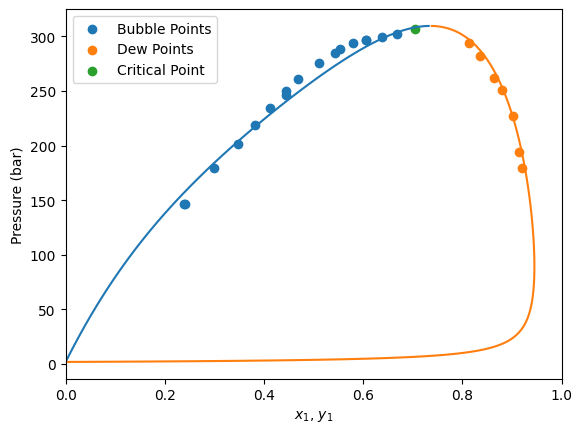

In [24]:
import matplotlib.pyplot as plt


gpec = yaeos.GPEC(model)
pxy = gpec.plot_pxy(T)


msk_bub = df["kind"] == "bubbleP"
msk_dew = df["kind"] == "dewP"
msk_critical = df["kind"] == "critical"

plt.scatter(df[msk_bub]["x1"], df[msk_bub]["P"], label="Bubble Points")
plt.scatter(df[msk_dew]["y1"], df[msk_dew]["P"], label="Dew Points")
plt.scatter(df[msk_critical]["x1"], df[msk_critical]["P"], label="Critical Point")

plt.xlim(0, 1)
plt.legend()
plt.show()